# Team information

| Team member 1     | Details  | Team member 2     | Details  |
| :---------------- | :------: | :---------------- | :------: |
| Name              | Nadia Victoria Aritonang         | Name              | Reiner Anggriawan Jasin |
| NUSNet (Exxxxxxx) | E1505949         | NUSNet (Exxxxxxx) | E1503344 |
| Matric (AxxxxxxxZ)| A0314698N         | Matric (AxxxxxxxZ)| A0314502W |


In [ ]:
# Connect to Google drive to save your model, etc.,

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation and setup

The gym environment requires an older version numpy (and corresponding packages). <br>
The following cell contains the `requirements.txt` to setup the python environment used in the rest of this notebook.


In [ ]:
%%writefile requirements.txt

cloudpickle==3.1.1
contourpy==1.3.0
cycler==0.12.1
filelock==3.18.0
fonttools==4.56.0
fsspec==2025.3.0
gym==0.26.2
gym-notices==0.0.8
importlib_metadata==8.6.1
importlib_resources==6.5.2
Jinja2==3.1.6
kiwisolver==1.4.7
MarkupSafe==3.0.2
matplotlib==3.9.4
mpmath==1.3.0
networkx==3.2.1
numpy==1.24.2
nvidia-cublas-cu12==12.4.5.8
nvidia-cuda-cupti-cu12==12.4.127
nvidia-cuda-nvrtc-cu12==12.4.127
nvidia-cuda-runtime-cu12==12.4.127
nvidia-cudnn-cu12==9.1.0.70
nvidia-cufft-cu12==11.2.1.3
nvidia-curand-cu12==10.3.5.147
nvidia-cusolver-cu12==11.6.1.9
nvidia-cusparse-cu12==12.3.1.170
nvidia-cusparselt-cu12==0.6.2
nvidia-nccl-cu12==2.21.5
nvidia-nvjitlink-cu12==12.4.127
nvidia-nvtx-cu12==12.4.127
packaging==24.2
pillow==11.1.0
ply==3.11
pygame==2.6.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
six==1.17.0
sympy==1.13.1
torch==2.6.0
tqdm==4.67.1
triton==3.2.0
zipp==3.21.0

Overwriting requirements.txt


Now install the requirements.

You may be asked to restart the session to load the installed versions of the packages. If so, restart the session and continue using the notebook

In [ ]:
!pip install -r requirements.txt

We will use a discretized version of
the [elevator domain](https://ataitler.github.io/IPPC2023/elevator.html) from the International Planning Competition, 2023.

Install the pyRDDL gym environment using the given repository.

In [ ]:
!pip install -q git+https://github.com/tasbolat1/pyRDDLGym.git --force-reinstall

## Install other packages if needed

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import itertools
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from collections import deque

from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
from IPython.display import Image, display, clear_output # for displaying gifs in colab
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

## Add more imports here as required
from collections import namedtuple

# Environment Initialization

In [ ]:
## IMPORTANT: Do not change the instance of the environment.
env = Elevator(instance = 5)

print('Discrete environment actions:')
print(env.disc_actions)
print('Continuous environment actions:')
print(env.base_env.action_space)
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")

/usr/local/lib/python3.11/dist-packages/pyRDDLGym/Examples /usr/local/lib/python3.11/dist-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
NewLanguage -> Example with new language features.
NewtonZero -> Example with Newton root-finding method.
PowerGen_discrete -> A simple power generation problem loosely modeled on the problem of unit commitment.
PowerGen_continuous -> A continuous simple power generation problem loosely modeled on the problem of unit commitment.
RecSim -> A problem of recommendation systems, with consumers and providers.
Traffic -> BLX/QTM traffic model.
UAV_discrete -> Discrete action space version of multi-UAV problem where a group of UAVs have to reach goal positions in the 3d Space.
UAV_continuous -> Continuous action space version of multi-UAV problem where a group 

/usr/local/lib/python3.11/dist-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


Discrete environment actions:
{0: ('e0_movcurdir_0',), 1: ('e0_movcurdir_1',), 2: ('e0_close_0',), 3: ('e0_close_1',), 4: ('e0_open_0',), 5: ('e0_open_1',)}
Continuous environment actions:
Dict('move-current-dir___e0': Discrete(2), 'open-door___e0': Discrete(2), 'close-door___e0': Discrete(2))
Observation space size for the discrete Elevator Environment: 225280


# Hyperparameters

In [ ]:
# Define hyperparameters

## IMPORTANT: <BEGIN> DO NOT CHANGE THIS CODE!
## GENERAL HYPERPARAMS
num_episodes = 3000
## IMPORTANT: <END> DO NOT CHANGE THIS CODE!

learning_rate = 0.05  # This is arbitrary and will be updated by the scheduler
batch_size = 64
clip_value = 1.0  # Gradient clipping value

## ALGO SPECIFIC HYPERPARAMS
# Update the hyperparams as necessary for your implementation

# Model Definition

Define your model here. You can rename the class `YourModel` appropriately and use it later in the code.
Note: In case of actor-critic or other models, all components must subclass `nn.Module`

- Your model should take in 11 inputs, which will be derived from the convert_state_to_list function.
- Your model should return 6 values corresponding to action logits or probabilities.

In [ ]:
class YourModel(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, output_size=6):
        super(YourModel, self).__init__()
        # Your model layers and initializations here
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x will be a tensor with shape [batch_size, 11]
        # Your forward pass logic here
        # Ensure the output has shape [batch_size, 6]
        x = self.fc1(x)
        x = F.relu(x)
        output = self.fc2(x)

        return output

# Feature Extraction

In [ ]:
## IMPORTANT: DO NOT CHANGE THIS CODE!
env_features = list(env.observation_space.keys())

def convert_state_to_list(state, env_features):
    out = []
    for i in env_features:
        out.append(state[i])
    return out

# Neural Net Initialization

In [ ]:
# Initialize the network and optimizer
input_size = len(env_features)
output_size = 6

# INITIALIZE OTHER NETWORK PARAMS HERE
hidden_size = 128

# INITIALIZE YOUR NETWORK HERE
your_network = YourModel(input_size, hidden_size, output_size)

# INIT OPTIMIZER - Adam is a good start, but you can try changing this as well
# optimizer = optim.Adam(
#     your_network.parameters(), lr=learning_rate
# )

optimizer = optim.RMSprop(
    your_network.parameters(), lr=learning_rate,
)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=num_episodes/100, gamma=0.9)   # Lr is factored by 0.9 for every 30 steps

In [ ]:
# Convert networks to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

your_network.to(device)

# Define other constructs (replay buffers, etc) as necessary

cuda:0


YourModel(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

## Gradient Clipping (Optional, you can use torch's version as well)

In [ ]:
# Define a function for gradient clipping
def clip_grads(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            # Clip by value
            # param.grad.data = torch.clamp(param.grad.data, -clip_value, clip_value)

            # Clip gradient with Norm 2 (similar to norm 1 but have square root)
            param.grad.data = torch.nn.utils.clip_grad_norm_(param.grad.data, clip_value, norm_type=2.0, error_if_nonfinite=False, foreach=None)

# Live Plotting Setup

In [ ]:
# Create a figure for plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Lists to store rewards and episode numbers
rewards_list = []
episodes = []

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, figure, ylabel="Total Rewards"):
    """Plot the live graph."""
    clear_output(wait=True)
    ax.clear()
    for label, data in data_dict.items():
        if label == "Total Reward":
            ax.plot(data, label=label, color="yellow", linestyle='--')

            # Compute and plot moving average for total reward
            ma = exponential_smoothing(data)
            ma_idx_start = len(data) - len(ma)
            ax.plot(range(ma_idx_start, len(data)), ma, label="Smoothed Value", linestyle="-", color="purple", linewidth=2)
        else:
            ax.plot(data, label=label)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    display(figure)


# RL Algorithm

In [ ]:
# Define the loss calculation function
def calculate_loss(batch):
    ## TODO - CALCULATE LOSS VALUE & RETURN IT
    state_tensor, action, reward, next_state_tensor, done = zip(*batch)

    state_tensor = torch.tensor(state_tensor, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    next_state_tensor = torch.tensor(next_state_tensor, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float16, device=device)

    q_values = your_network(state_tensor)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = your_network(next_state_tensor)
        next_q_value = next_q_values.max(1)[0]
        target_q_value = reward + (1 - done) * 0.99 * next_q_value  # Discounted reward

    loss = F.mse_loss(q_value, target_q_value.detach())

    return loss

In [ ]:
def choose_action(state_tensor, epsilon=0.1):
    ## TODO - RETURN AN INTEGER FROM 0 - 5 (both inclusive) based on your model training/testing strategy

    if random.random() < epsilon:
      return random.randint(0, output_size - 1)
    else:
      state_dimension = state_tensor.unsqueeze(0)

      with torch.no_grad():
        q_values = your_network(state_dimension)

      return torch.argmax(q_values).item()

In [ ]:

Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(10000)


## Training loop with live plotting

Use the graph generated here in your pdf submission.

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Create a tqdm progress bar
progress_bar = tqdm.tqdm(range(num_episodes), postfix={'Total Reward': 0, 'Loss': 0})

# RL algorithm training loop
for episode in progress_bar:
    total_reward = 0
    state = env.reset()

    while True:
        # Convert the original state to the suitable format for the network
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device)

        action = choose_action(state_tensor, epsilon=max(0.01, 0.1 * (0.99 ** episode)))

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step((action))

        # For debugging
        # print(f'reward {reward}')

        # Convert the next state to the suitable format for the network
        next_state_desc = env.disc2state(next_state)
        next_state_list = convert_state_to_list(next_state_desc, env_features)
        next_state_tensor = torch.tensor(next_state_list, dtype=torch.float32, device=device)


        # Hint: You may want to collect experiences from the environment to update the agent in batches!

        memory.push(state_list, action, reward, next_state_list, done)

        if len(memory) > batch_size:
            batch = memory.sample(batch_size)
            # print(f'batch {batch}')
            loss = calculate_loss(batch)

            optimizer.zero_grad()

            clip_grads(your_network, clip_value)      # Gradient Clipping

            loss.backward()
            optimizer.step()

        state = next_state
        total_reward += reward

        # For debugging
        # print(f'total reward: {total_reward}')

        if done:
            break


    rewards_list.append(total_reward)
    episodes.append(episode)

    live_plot({'Total Reward': rewards_list}, fig)

    scheduler.step()

    # Saving the model
    if episode%500 == 0:
      torch.save(your_network, f'model.pt')

    progress_bar.set_postfix({'Total Reward': total_reward, 'Loss': loss.item(), 'lr': scheduler.get_lr()})

## Compute the mean rewards

Report the mean rewards obtained in your pdf submission

In [ ]:
mean_reward = np.mean(rewards_list)

print(f"\nMean Rewards: {mean_reward}")

In [ ]:

# close the environment
env.close()

# Report

**1. What is the mean rewards obtained by our agent?**  
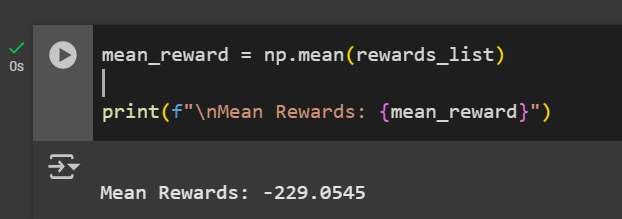  
The mean obtained by our agent is -229.0545


**2. Briefly state and explain the algorithm you chose and the hyperparams used.**  
The algorithm we used for this problem is the Deep Q-Networks (DQN) algorithm, a deep reinforcement learning algorithm introduced by Mnih et al. (2015). DQNs utilize the concept of Q-networks, which are used to estimate the rewards from an action taken by the agent (Silver, 2016). DQNs represent these Q-networks through deep neural networks. The DQN also has a replay memory which saves the agent’s history (the current and next state, action it performed, and reward obtained).

How our Deep Q-Networks algorithm works:
1. Initialize 2 layer MLP network
2. Choose the next action from the list of possible actions in the current state.
We use an epsilon greedy approach to balance exploration and exploitation, where we generate a random decimal.  
  - If the decimal is lower than our selected epsilon, choose the next action randomly
  - If the decimal is the same or higher than our selected epsilon, feed the actions to the network and choose the action that produced the highest Q value.
3. Continue to the next state based on the selected action.
4. Save the states, action taken, and reward produced into the replay memory, which is used to update the weights of our network.

We chose this algorithm because it is a derivation of the Q-Learning approach which works with discrete state-action spaces such as in the elevator problem (Sutton & Barto, 2018).

**Hyperparameters used**  
- Initial learning rate = 0.05
  - We also use a learning rate scheduler that reduces the learning rate with a factor of 0.9 every 30 steps. This will give us a constant decrease that will reach 1.195e-06 on the last 30 steps.
- Batch size = 64
- Clip value = 1.0
  - We tried doing the gradient clipping by experimenting with different clip_value using the ‘clip by value’ method and the ‘norm’ method. After a few iterations, we decided to use the L2 Norm Gradient Clipping as it gives us a more stable result with no risk of extreme reward dropping that we observed previously by using the L1 Norm Gradient Clipping.
  - Based on what we analyze, this issue is caused by the calculation where the L2 norm calculates the square root which eliminates an extremely high number by a major factor which acts as a stabilizer unlike the L1 method that only takes absolute value that is prone to extreme large gradient results (GeeksForGeeks, 2024).
- Network Architecture  
```
YourModel(
  (fc1): Linear(in_features=13, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
```
  - We only use 2 linear layers which take the number of states (13) as input and number of actions (6) as output. For the hidden size, we put 128 as we want to have sufficient neurons to do a decent function approximation. We design the architecture to match the Universal Approximation theory which allows us to approximate a continuous function. <br><br>

> All of the hyperparameters were chosen through exploration and experimentation step. The hyperparameters used in this code were the ones that gave the best results.

**3. Write insights based on the analysis.**

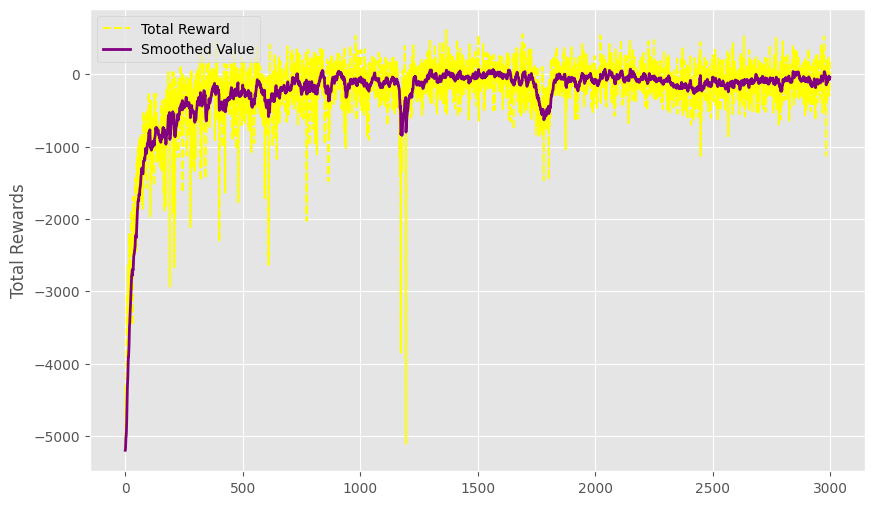

In the initial epochs (0 to around 100), there is a steep increase of total rewards. This shows that the agent is learning effectively to find the policies because of the improvements in total reward value. After that, from epochs 100 to around 600, the fluctuation in the total rewards becomes more stable and still shows an increase in value. Afterwards, the smoothed total rewards remain steady in between -1000 to 0. As the number epoch increases, the scheduler will reduce the learning_rate which makes the oscillation converge overtime. However, there are some noticeable drops on the total reward on epoch 1200 and 1600. But then our model is able to balance the learning and get back on its stable state. <br><br>

By analyzing our past results of the mean reward, we believe that it is very challenging for the model to reach rewards larger than 0. As none of our numerous experiments on the learning rate scheduler and gradient clipping method and value yield better results. However, there are some approaches that we wish to try such as the adaptive gradient clipping method, which is a more advanced method than the L2 that we used in this project. And also different types of DQN algorithms that might fit the elevator problem better.

> **Help:**
During the coding of this assignment, we used ChatGPT to help create the initial model structure and do debugging.


References:  
* Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., . . . Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529–533. https://doi.org/10.1038/nature14236
* Silver, D. (2016, June 17). Deep Reinforcement Learning. Retrieved April 18, 2025, from https://deepmind.google/discover/blog/deep-reinforcement-learning/
* Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning, second edition: An Introduction. MIT Press.
* GeeksforGeeks. (2024, January 18). Understanding gradient clipping. GeeksforGeeks. https://www.geeksforgeeks.org/understanding-gradient-clipping/
